# Comparing tree topologies by depth

## Summary

Compare the topologies of two trees with consideration of phylogenetic depth.

This involves the measurement of "phylogenetic depth" (jargons: **deep** - close to root; **shallow** - close to tips). Two methods can be used: with, or without consideration of branch lengths.

The functions implemented here have been further optimized and added to `tree.py`, as `calc_split_metrics` and `calc_length_metrics`.

## Dependencies

In [1]:
from os import listdir
from os.path import join

In [2]:
from math import exp
from statistics import mean, median

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
from skbio.tree import TreeNode

In [5]:
%matplotlib inline

In [6]:
mpl.rcParams['figure.figsize'] = (15, 4)

## Input trees

In [7]:
trees = {}
trees_dir = 'trees'
for fname in listdir(trees_dir):
    if fname.endswith('.nwk'):
        trees[fname.rsplit('.', 1)[0]] = TreeNode.read(join(trees_dir, fname))
trees.keys()

dict_keys(['concat.rand.b50', 'astral.rand', 'concat.rand', 'concat.cons.b50', 'astral.cons', 'astral.cons.e5p50', 'astral', 'astral.rand.e5p50', 'concat.cons', 'astral.e5p50'])

## Metrics

Compute the following metrics for internal nodes:
 - `n`: number of descendants
 - `taxa`: list of names of the descendants
 - `postlevels`: maximum number of splits from the tips
 - `prelevels`: number of splits from the root
 - `split_depth`: total number of splits from the tips (see [Puigbò et al., 2009](https://jbiol.biomedcentral.com/articles/10.1186/jbiol159))
 - `depths`: list of depths (sum of branch lengths from a tip to the node)
 - `height`: sum of branch lengths from the root to the node

In [8]:
for name in trees:
    for node in trees[name].postorder(include_self=True):
        if node.length is None:
            node.length = 0.0
        if node.is_tip():
            node.n = 1
            node.taxa = [node.name]
            node.postlevels = 1
            node.split_depth = 0
            node.depths = [0.0]
        else:
            node.n = sum(x.n for x in node.children)
            node.taxa = sorted(set().union(*[x.taxa for x in node.children]))
            node.postlevels = max(x.postlevels for x in node.children) + 1
            node.split_depth = sum(x.split_depth for x in node.children) + 1
            node.depths = [y + x.length for x in node.children for y in x.depths]
    for node in trees[name].preorder(include_self=True):
        if node.is_root():
            node.prelevels = 1
            node.height = 0.0
        else:
            node.prelevels = node.parent.prelevels + 1
            node.height = node.parent.height + node.length

Extra metrics for the depths (mean, median, max, min, etc.)

In [9]:
for name in trees:
    for node in trees[name].non_tips(include_self=True):
        node.max_depth = max(node.depths)
        node.min_depth = min(node.depths)
        node.mean_depth = mean(node.depths)
        node.median_depth = median(node.depths)

We need these metrics:

In [10]:
attrs = ['n', 'prelevels', 'postlevels', 'split_depth', 'height', 'mean_depth', 'median_depth']

Count the overlapping nodes (those with the same set of descendants) between two trees.

In [11]:
def count_overlapping_nodes(tree1, tree2):
    taxas = [x.taxa for x in tree2.non_tips(include_self=True)]
    data = []
    for node in tree1.preorder(include_self=True):
        if node.is_tip():
            continue
        is_match = False
        for taxa in taxas:
            if node.taxa == taxa:
                is_match = True
                break
        row = [node.name, is_match]
        for attr in attrs:
            row.append(getattr(node, attr))
        data.append(row)
    return pd.DataFrame(data, columns=['id', 'is_match'] + attrs)

In [12]:
df = count_overlapping_nodes(trees['astral.cons'], trees['concat.cons'])
df.head()

,id,is_match,n,prelevels,postlevels,split_depth,height,mean_depth,median_depth
0,N1,True,10575,1,67,10574,0.000000,0.973419,0.971197
1,N2,True,669,2,35,668,0.061071,0.923035,0.900001
2,N4,True,4,3,3,3,0.185774,0.582115,0.581432
3,N8,True,2,4,2,1,0.437867,0.330706,0.330706
4,N9,True,2,4,2,1,0.304846,0.462360,0.462360


### Plot the correlation

In [13]:
attr = 'split_depth'
df[attr].describe()

count    10574.000000
mean        28.860318
std        252.249727
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max      10574.000000
Name: split_depth, dtype: float64

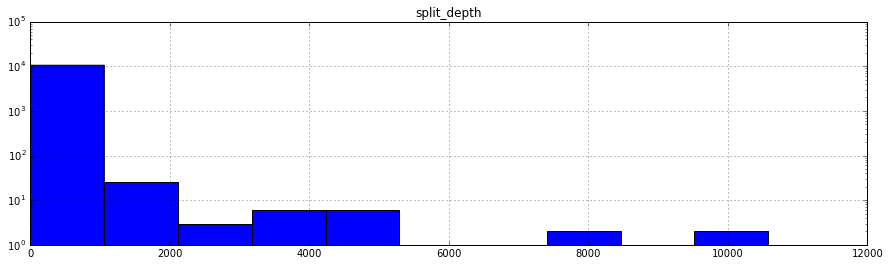

In [14]:
df.hist(attr, log=True);

#### Plan A: Cut to even numbers of nodes

Note: May not work when there are many identical small integers.

In [15]:
bin_num = 20
bin_size = int(df.shape[0] / bin_num)
bin_size

528

In [16]:
bound, matches = 0, []
data = []
for i, (is_match, val) in enumerate(df[['is_match', attr]].sort_values(attr).itertuples(False)):
    matches.append(is_match)
    if (i + 1) % bin_size == 0:
        data.append([bound, matches.count(True) / len(matches)])
        bound, matches = val, []

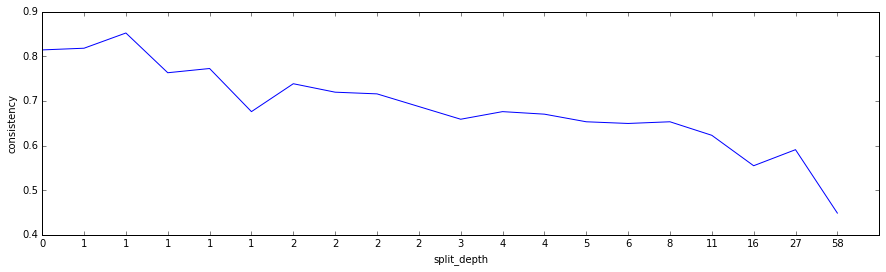

In [17]:
bounds = [x[0] for x in data]
values = [x[1] for x in data]
plt.plot(values)
plt.xticks(range(len(data)), bounds)
plt.xlabel(attr)
plt.ylabel('consistency');

#### Plan B: Cut to designated value ranges

The binning scheme has to be manually determined.

In [18]:
attr = 'split_depth'

In [19]:
%%script false
bounds = sorted(set(int(exp(x / 10)) for x in list(range(80))))
print('Lower bounds: %s.' % bounds)
print('Number of bins: %d.' % (len(bounds) - 1))

In [20]:
%%script false
bounds = [0] + sorted(set(int(exp(x / 5)) for x in list(range(40)))) + [df[attr].max()]
print('Lower bounds: %s.' % bounds)
print('Number of bins: %d.' % (len(bounds) - 1))

In [21]:
%%script false
bounds = [0] + sorted(set(int(exp(x / 4)) for x in list(range(30))))
print('Lower bounds: %s.' % bounds)
print('Number of bins: %d.' % (len(bounds) - 1))

In [22]:
# the chosen scheme
bounds = [0] + sorted(set(int(exp(x / 5)) for x in list(range(40))))[:-3] + [2440] + [df[attr].max()]
print('Lower bounds: %s.' % bounds)
print('Number of bins: %d.' % (len(bounds) - 1))

Lower bounds: [0, 1, 2, 3, 4, 6, 7, 9, 11, 13, 16, 20, 24, 29, 36, 44, 54, 66, 81, 99, 121, 148, 181, 221, 270, 330, 403, 492, 601, 735, 897, 1096, 1339, 2440, 10574].
Number of bins: 34.


Group nodes by bins

In [23]:
gb = df['is_match'].groupby(pd.cut(df[attr], bins=bounds))
dfx = pd.concat([gb.size(), gb.sum().fillna(0).astype(int)], axis=1)
dfx.columns = ['size', 'matches']
dfx['consistency'] = (dfx['matches'] / dfx['size'] * 100).fillna(0)
dfx.head()

,size,matches,consistency
split_depth,,,
"(0, 1]",3119,2442,78.294325
"(1, 2]",1643,1192,72.550213
"(2, 3]",1031,697,67.604268
"(3, 4]",704,470,66.761364
"(4, 6]",918,609,66.339869


Check if there is any bin with n < 5. They were manually merged to the next bin.

In [24]:
for row in dfx.itertuples():
    if row.size < 5:
        print(row.Index)

Plot consistency (%) versus the attribute.

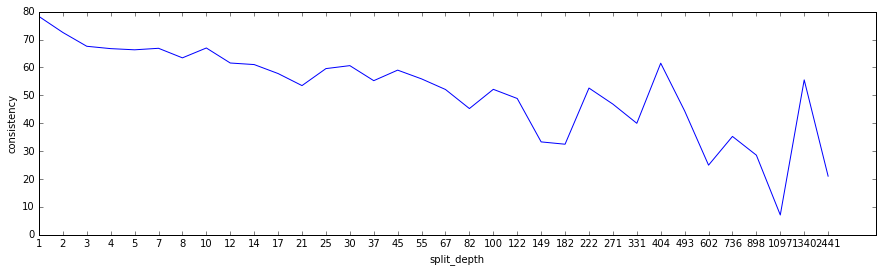

In [25]:
plt.plot(dfx['consistency'].tolist())
plt.xticks(range(dfx.shape[0]), [x + 1 for x in bounds])
plt.xlabel(attr)
plt.ylabel('consistency');

Overlay the other tree

In [27]:
df2 = count_overlapping_nodes(trees['astral.rand'], trees['concat.rand'])
gb2 = df2['is_match'].groupby(pd.cut(df2[attr], bins=bounds))
dfx2 = pd.concat([gb2.size(), gb2.sum().fillna(0).astype(int)], axis=1)
dfx2.columns = ['size', 'matches']
dfx2['consistency'] = (dfx2['matches'] / dfx2['size'] * 100).fillna(0)
dfx2.head()

,size,matches,consistency
split_depth,,,
"(0, 1]",3119,2545,81.596666
"(1, 2]",1643,1268,77.175898
"(2, 3]",1031,782,75.848691
"(3, 4]",704,508,72.159091
"(4, 6]",918,653,71.132898


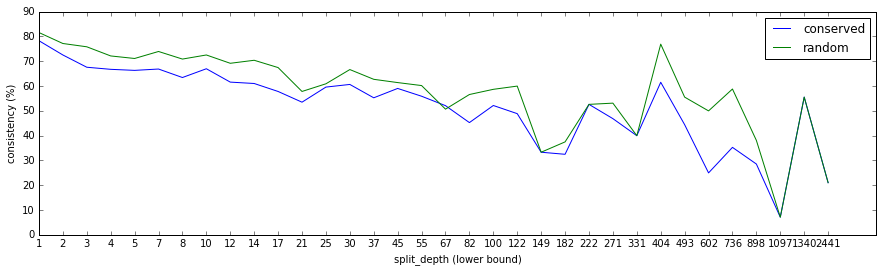

In [32]:
fig = plt.figure()
plt.plot(dfx['consistency'].tolist())
plt.plot(dfx2['consistency'].tolist())
plt.xticks(range(dfx.shape[0]), [x + 1 for x in bounds])
plt.xlabel('%s (lower bound)' % attr)
plt.ylabel('consistency (%)')
plt.legend(['conserved', 'random'], loc='upper right');

In [34]:
fig.savefig('total.pdf')

Plot population sizes

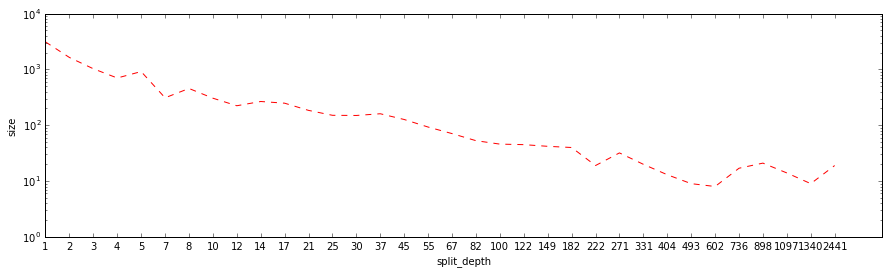

In [35]:
fig = plt.figure()
plt.plot(dfx['size'].tolist(), ls='--', color='r')
plt.xticks(range(dfx.shape[0]), [x + 1 for x in bounds])
plt.xlabel(attr)
plt.ylabel('size')
plt.yscale('log', basey=10);

In [36]:
fig.savefig('total_size.pdf')

Postlevels (maximum number of splits from node to tip)

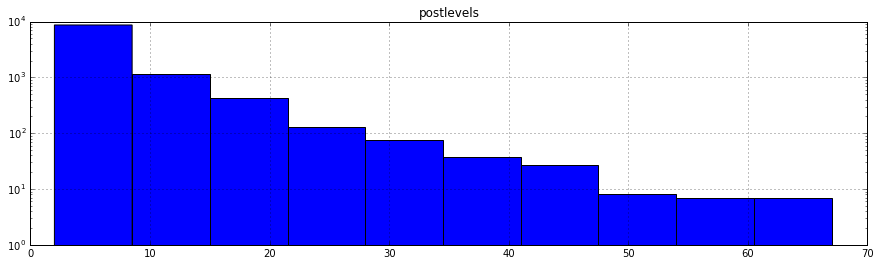

In [37]:
attr = 'postlevels'
df.hist(attr, log=True);

In [38]:
bounds = sorted(set(int(exp(x / 5)) for x in list(range(20)))) + [df['postlevels'].max()]
print('Lower bounds: %s.' % bounds)
print('Number of bins: %d.' % (len(bounds) - 1))

Lower bounds: [1, 2, 3, 4, 6, 7, 9, 11, 13, 16, 20, 24, 29, 36, 44, 67].
Number of bins: 15.


In [39]:
gb = df['is_match'].groupby(pd.cut(df[attr], bins=bounds))
dfx = pd.concat([gb.size(), gb.sum().fillna(0).astype(int)], axis=1)
dfx.columns = ['size', 'matches']
dfx['consistency'] = (dfx['matches'] / dfx['size'] * 100).fillna(0)

In [40]:
gb2 = df2['is_match'].groupby(pd.cut(df2[attr], bins=bounds))
dfx2 = pd.concat([gb2.size(), gb2.sum().fillna(0).astype(int)], axis=1)
dfx2.columns = ['size', 'matches']
dfx2['consistency'] = (dfx2['matches'] / dfx2['size'] * 100).fillna(0)

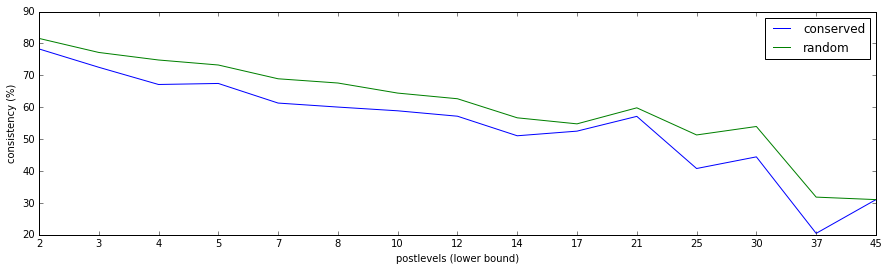

In [42]:
fig = plt.figure()
plt.plot(dfx['consistency'].tolist())
plt.plot(dfx2['consistency'].tolist())
plt.xticks(range(dfx.shape[0]), [x + 1 for x in bounds])
plt.xlabel('%s (lower bound)' % attr)
plt.ylabel('consistency (%)')
plt.legend(['conserved', 'random'], loc='upper right');

In [43]:
fig.savefig('max.pdf')

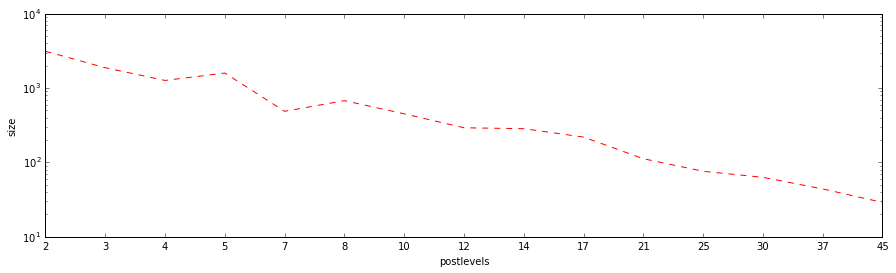

In [44]:
fig = plt.figure()
plt.plot(dfx['size'].tolist(), ls='--', color='r')
plt.xticks(range(dfx.shape[0]), [x + 1 for x in bounds])
plt.xlabel(attr)
plt.ylabel('size')
plt.yscale('log', basey=10);

In [45]:
fig.savefig('max_size.pdf')